# Looking at effet effect of changing analysis parameters $L$ and $\epsilon^2$

# Reading data as before

In [1]:
import divand
using PyPlot

In [2]:
varname = "Salinity"
filename = "WOD-Salinity-Provencal.nc"


if !isfile(filename)    
    download("https://b2drop.eudat.eu/s/UsF3RyU3xB1UM2o/download",filename)
end

value,lon,lat,depth,obstime,ids = divand.loadobs(Float64,filename,"Salinity");

.CFVocab})(Any) in module Vocab at C:\Users\jmbeckers\.julia\v0.6\divand\src\Vocab.jl:22 overwritten at C:\Users\jmbeckers\.julia\v0.6\divand\src\Vocab.jl:46.


# Topography and grid definition. 

See other notebook for explanation. Here just code replicated to get topography defining the mask

In [3]:
dx = dy = 0.125/2.
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

mask,(pm,pn),(xi,yi) = divand.divand_rectdom(lonr,latr)

bathname = "gebco_30sec_4.nc"




if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download",bathname)
else
    info("Bathymetry file already downloaded")
end


bx,by,b = divand.load_bath(bathname,true,lonr,latr)



mask = falses(size(b,1),size(b,2))


    for j = 1:size(b,2)
        for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
        end
    end


INFO: Bathymetry file already downloaded


# Data selection for example

Cross validation, error calculations etc assume independant data. Hence do not take high resolution vertical profiles with all data but restrict yourself to specific small depth range. Here August data at surface:

In [4]:
sel = (depth .< 1) .& (Dates.month.(obstime) .== 8)

value = value[sel]
lon = lon[sel]
lat = lat[sel]
depth = depth[sel]
obstime = obstime[sel]
ids = ids[sel];
@show (size(value))
divand.checkobs((lon,lat,depth,obstime),value,ids)

size(value) = (1956,)
              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (1910-08-09T00:00:00, 2014-08-28T19:36:00)
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


# Analysis

Analysis fi using mean data as background. Structure s is stored for later use.  Here a loop on different values for $L$ and $\epsilon^2$

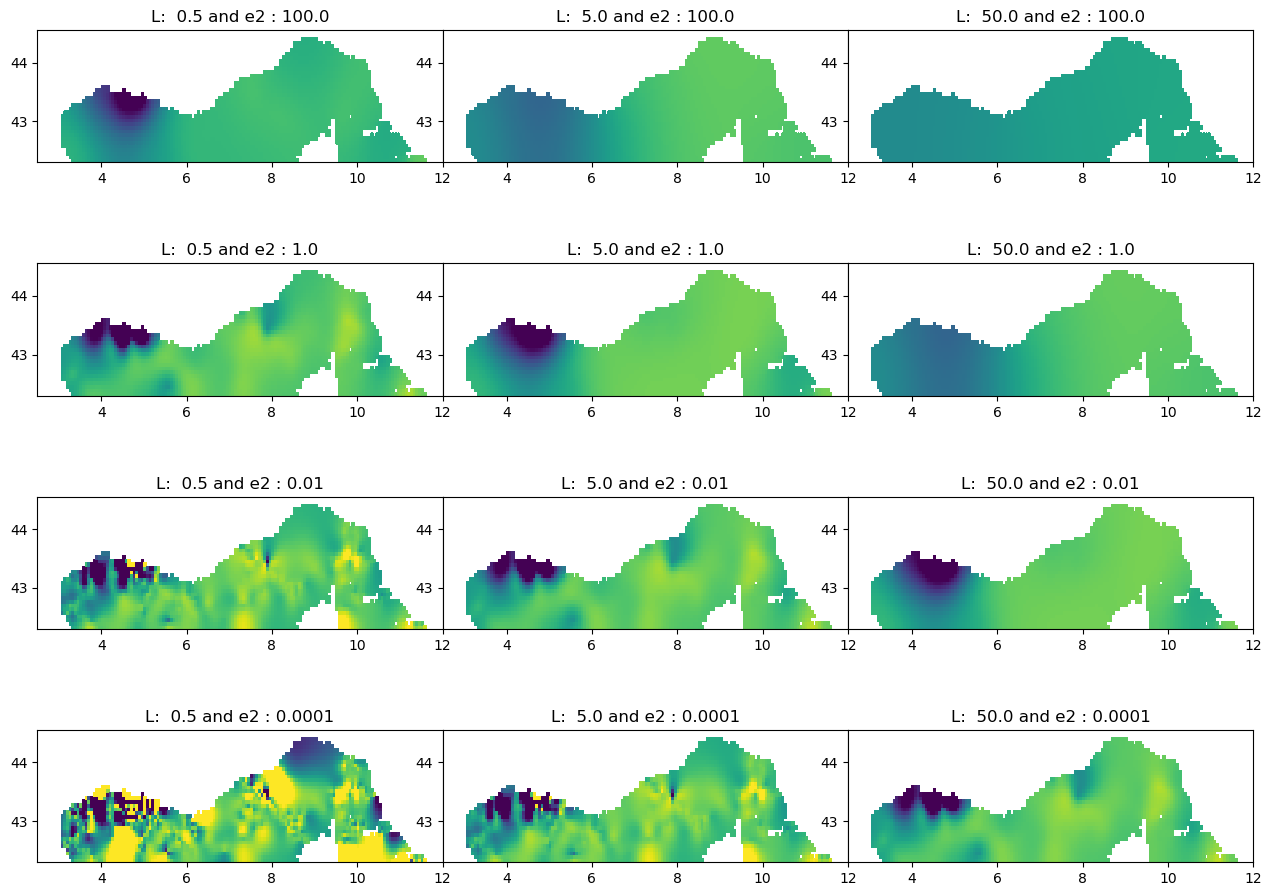

In [124]:
subplots_adjust(left = 0.1, bottom = 0.1, right = 2, top = 2, wspace = 0, hspace = 0.1)
for i=1:3
    for j=0:3
        len=5*10.0^(i-2)
        epsilon2=10.0^(-2*j+2)
        #@show i,j,len*sqrt(epsilon2),len,epsilon2
        fi,s = divand.divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value-mean(value),len,epsilon2;alphabc=0);
        subplot(4,3,3*j+i)
        pcolor(xi,yi,fi+mean(value),vmin=37,vmax=38.5);#colorbar(orientation="horizontal")
        gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
        title("L:  $len and e2 : $epsilon2")
        
    end
end

# But which combination to use ?

Visual inspection tells you which analyses are abvisouly (?) too noisy or too smooth. Also some suspect data points are seen when $L$ and $\epsilon^2$ are small.

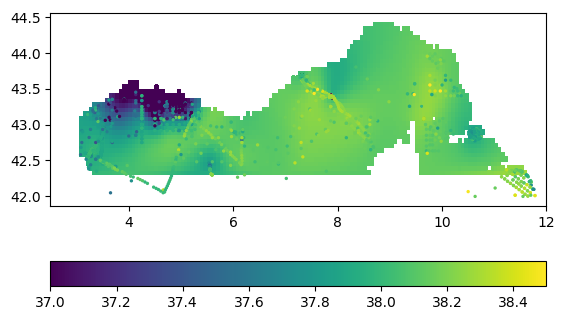

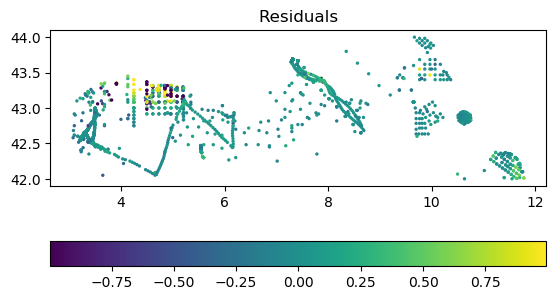

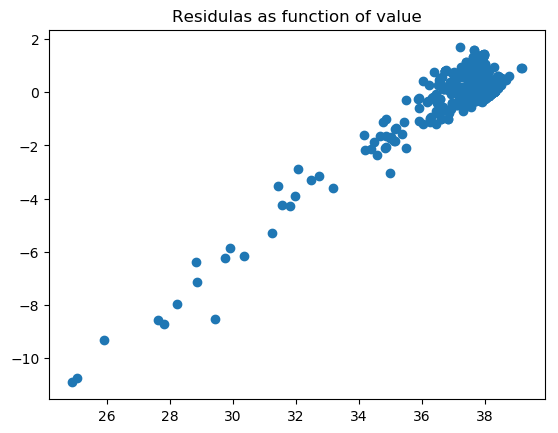

In [127]:
figure()

len=1
epsilon2=1
fi,s = divand.divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value-mean(value),len,epsilon2);

pcolor(xi,yi,fi+mean(value),vmin=37,vmax=38.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
dataresiduals=divand.divand_residualobs(s,fi)
scatter(lon,lat,s=2,c=value,vmin=37,vmax=38.5)




rscale=sqrt(var(value))

figure()
scatter(lon,lat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Residuals")


figure()
scatter(value,dataresiduals)
title("Residulas as function of value");


Note how residuals change (decrease if you decrease $\epsilon^2$). But beware, low residuals is not necessarily a good sign as the analysis used the data points to which you compare your analysis

In [120]:
var(dataresiduals),var(value),var(fi[(fi.!==NaN)])

(0.309922095616278, 0.990346699659609, 0.61476939051695)

# Exercise

Change parameters $L$ or $\epsilon^2$ and see what happens (do not rerun the whole notebook, just the last cells)

# Remember: analyses are not very sensitive to changes in $L$ or $\epsilon^2$ if $L$ $\sqrt{\epsilon^2}$ remains constant. To see changes in the analysis you need significant changes in  $L$ or $\epsilon^2$ changing $L$ $\sqrt{\epsilon^2}$. A few percent changes on the parameters does not really modify things even if $L$ $\sqrt{\epsilon^2}$ changes.